In [81]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

In [82]:
stock_data = ACP_data.stock_data(100)

In [144]:
from scipy.optimize import minimize

class hACP(AdaptiveCP):
    '''This class will implement the hACP method.'''

    @staticmethod
    def pinball_loss_function(target, y, y_hat):
        return (target * (y - y_hat)) - min(0, (y - y_hat))

    def conditional_quantile_loss(self, params: list, target: float, dataset: list[tuple]):
        ''' This function will workout the loss if we were to uset the lambda_const and lambda_var provided.'''

        # We are treating each return as independent. So we need to get the returns so need to find the differences. This means we have to ignore the first datapoints.
        zipped_data_set = zip(dataset[0], dataset[1]) 
        loss_list = [hACP.pinball_loss_function(target, y, (params[0] + params[1] * var)) for var, y in zipped_data_set]

        return sum(loss_list)

    def HACI(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
        ''' Implementation of the Adaptive Conformal Prediction method.'''
        xpred, varpred, y = timeseries_with_var_data

        alpha_t_list = [self.coverage_target]
        lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
        params_t_list = {'lower': [(0,0)],
                         'upper': [(0,0)]} # params list. with the inital guess.


        # y> xpred means positive score.
        All_scores = y - xpred 

        err_t_list = []
        conformal_sets_list = []

        if startpoint is None:
            if custom_interval is not None:
                startpoint = max(custom_interval, self.interval_size) + 1
            else:
                startpoint = self.interval_size + 1

        for i in range(startpoint, len(All_scores)):
            # We need to replace this.
        
            # Fitting the upper and lower parameters.
            lower_params = minimize(self.conditional_quantile_loss, params_t_list['lower'][-1], 
                                    bounds=lower_bound, args=(alpha_t_list[-1]/2, (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
            
            upper_params = minimize(self.conditional_quantile_loss, params_t_list['upper'][-1],
                                    bounds=upper_bound, args=(1-alpha_t_list[-1]/2, (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
        
            params_t_list['lower'].append(lower_params)
            params_t_list['upper'].append(upper_params)

            # Using fitted values to create the conformal set.
            lower_bound_t = lower_params[0] + lower_params[1] * varpred[i]
            upper_bound_t = upper_params[0] + upper_params[1] * varpred[i]
            
            conformal_set = (xpred[i] + min(0, lower_bound_t), xpred[i] + max(0, upper_bound_t))

            conformal_sets_list.append(conformal_set)

            # Updating the alpha_t.
            error_t = AdaptiveCP.err_t(y[i], conformal_set)
            err_t_list.append(error_t)

            #alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        # Calculating different metrics.
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
            'model': title if title is not None else 'ACI',
            'coverage_target': self.coverage_target,
            'gamma': gamma,
            'realised_interval_coverage': realised_interval_coverage,
            'alpha_t_list': alpha_t_list,
            'average_prediction_interval': average_prediction_interval,
            'conformal_sets': conformal_sets_list,
            'error_t_list': err_t_list, 
            'interval_size': self.interval_size,
            'params_t_list': params_t_list,

        }
    
    def HACI_one_side(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
            ''' Implementation of the Adaptive Conformal Prediction method.'''
            xpred, varpred, y = timeseries_with_var_data

            alpha_t_list = [self.coverage_target]
            bound = [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
            params_t_list = [[0,0]]# params list. with the inital guess.


            # y> xpred means positive score.
            All_scores = abs(y - xpred)

            err_t_list = []
            conformal_sets_list = []

            if startpoint is None:
                if custom_interval is not None:
                    startpoint = max(custom_interval, self.interval_size) + 1
                else:
                    startpoint = self.interval_size + 1

            for i in range(startpoint, len(All_scores)):
                # We need to replace this.
            
                # Fitting the upper and lower parameters.
                
                params = minimize(self.conditional_quantile_loss, params_t_list[-1],
                                        bounds=bound, args=(1-alpha_t_list[-1], (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
            
                params_t_list.append(params)

                # Using fitted values to create the conformal set.
                pred_score_t = params[0] + params[1] * varpred[i]
         
                conformal_set = (xpred[i]  - max(0, pred_score_t), xpred[i] + max(0, pred_score_t))

                conformal_sets_list.append(conformal_set)

                # Updating the alpha_t.
                error_t = AdaptiveCP.err_t(y[i], conformal_set)
                err_t_list.append(error_t)

                #alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            # Calculating different metrics.
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                'model': title if title is not None else 'ACI',
                'coverage_target': self.coverage_target,
                'gamma': gamma,
                'realised_interval_coverage': realised_interval_coverage,
                'alpha_t_list': alpha_t_list,
                'average_prediction_interval': average_prediction_interval,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list, 
                'interval_size': self.interval_size,
                'params_t_list': params_t_list,

            }
    
    def HACI_dual_tail(self, timeseries_with_var_data: tuple, gamma: float = 0.05, custom_interval = None, title: str = None, startpoint: int = None) -> dict:
        ''' Implementation of the Adaptive Conformal Prediction method.'''
        xpred, varpred, y = timeseries_with_var_data

        # Need to turn this into a dict, as will save to alpha_t_lists.
        alpha_t_dict = {'lower': [self.coverage_target/2],
                        'upper': [self.coverage_target/2]}
        
        lower_bound, upper_bound = [(None, 0), (None, None)], [(0, None), (None, None)] # We will not allow the constant term to allow for nosensical predictions.
        
        params_t_list = {'lower': [(0,0)],
                         'upper': [(0,0)]} # params list. with the inital guess.


        # y> xpred means positive score.
        All_scores = y - xpred 

        err_t_list = []
        conformal_sets_list = []

        if startpoint is None:
            if custom_interval is not None:
                startpoint = max(custom_interval, self.interval_size) + 1
            else:
                startpoint = self.interval_size + 1

        for i in range(startpoint, len(All_scores)):
            # These need to change to correspond to the right alpha_t, values.
        
            # Fitting the upper and lower parameters.
            lower_params = minimize(self.conditional_quantile_loss, params_t_list['lower'][-1], 
                                    bounds=lower_bound, args=(alpha_t_dict['lower'][-1], (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
            
            upper_params = minimize(self.conditional_quantile_loss, params_t_list['upper'][-1],
                                    bounds=upper_bound, args=(1-alpha_t_dict['upper'][-1], (varpred[i-self.interval_size:i], All_scores[i-self.interval_size:i]))).x
        
            params_t_list['lower'].append(lower_params)
            params_t_list['upper'].append(upper_params)

            # Using fitted values to create the conformal set.
            lower_bound_t = lower_params[0] + lower_params[1] * varpred[i]
            upper_bound_t = upper_params[0] + upper_params[1] * varpred[i]
            
            conformal_set = (xpred[i] + min(0, lower_bound_t), xpred[i] + max(0, upper_bound_t))

            conformal_sets_list.append(conformal_set)

            # Updating the alpha_t.
            error_t = AdaptiveCP.err_t(y[i], conformsal_set)
            err_t_list.append(error_t)

            # Here we need to update them seperately. You shoudl update conditional on whether the prediction is above or below.
            # if y[i] > xpred[i]: # Over prediction corresponds to the upperbound.
            #     new_alpha_t = min(max(alpha_t_dict['upper'][-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            #     alpha_t_dict['upper'].append(new_alpha_t)
            # else:
            #     new_alpha_t = min(max(alpha_t_dict['lower'][-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            #     alpha_t_dict['lower'].append(new_alpha_t)

        # Calculating different metrics.
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
        average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

        return {
            'model': title if title is not None else 'ACI',
            'coverage_target': self.coverage_target,
            'gamma': gamma,
            'realised_interval_coverage': realised_interval_coverage,
            'alpha_t_list': alpha_t_dict['upper'], # This is a legacy artefact.
            'alpha_t_dict': alpha_t_dict,
            'average_prediction_interval': average_prediction_interval,
            'conformal_sets': conformal_sets_list,
            'error_t_list': err_t_list, 
            'interval_size': self.interval_size,
            'params_t_list': params_t_list,

        }

        


    


In [101]:
# Creating the method for creating the data.
def create_nomrmal_cheb_data(length: int, model_error: float = 0.1, time_series_function: callable = lambda x: x, var_range: tuple = (0.5, 2)) -> tuple:
    minv, maxv = var_range

    true_variance_array = np.random.uniform(minv, maxv, length)
    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + np.random.uniform(model_error*minv, model_error*maxv, length)
    time_series_normal = time_series_function(corresponding_normal)

    # Now we need to return as xpred, varpred, y
    # The variance is the prediction for the same time step. 
    # Hence you need to ignore the first value for the variance as you do for the true value.
    
    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])

def create_hetroskedatic_cheb_data(length: int, model_error: float = 0.1, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''  

    # We will simulate a random walk for the variance. Might do a exponenital random walk as 
    # then no issues with negative values.

    exp_random_walk = np.random.normal(0, 0.1, length)
    true_variance_array = np.exp(np.cumsum(exp_random_walk))

    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + (true_variance_array * np.random.uniform(model_error, 2-model_error, length))
    time_series_normal = np.cumsum(corresponding_normal)

    # Now we need to return as xpred, varpred, y

    return (time_series_normal[:-1], model_variance_array[1:], time_series_normal[1:])


def xvy_from_y(series, lookback: int = -1):
    '''This function will create the x, var and y series from the y series.'''
    
    if lookback == -1:
        lookback = len(series) # This results in all data being used.

    x = series[:-1]
    y = series[1:]

    # Calculating the series of sample variances of a length lookback.
    var = [np.var(series[max(0, i - lookback):i+1]) for i in range(1, len(series))]

    return x, var, y

def xvy_from_ACP(dataset, lookback: int = -1):
    lookback = len(dataset) if lookback == -1 else lookback
    final = []
    for x, y in dataset:
        var = [np.var(x[max(0, i - lookback):i+1]) for i in range(1, len(x))] # We need to ignore the first value.
        final.append((x[1:], var, y[1:]))

    return final

def xvy_correction(dataset):
    return [(x[0][1:], x[1][1:]) for x in dataset]
    

In [114]:
def test():
    stock = [stock_data[random.randint(0,99)]]
    final_stock = xvy_from_ACP(stock)[0]
    h = hACP(0.1, 200)
    result = h.HACI(final_stock, 0.005)
    ACP_plots.one_plot(result, final_stock[2])
    return result

def test_with_comparison():
    stock = [stock_data[random.randint(0,99)]]
    cleaned_stock_data = xvy_from_ACP(stock,)[0]
    corrected_stock_data = xvy_correction(stock)[0]

    h = hACP(0.1, 200)
    result = h.HACI(cleaned_stock_data, 0.005, title='hACI')
    comparison = h.ACI(corrected_stock_data, 0.005)

    ACP_plots.one_plot(result, cleaned_stock_data[2])
    ACP_plots.compare_two(result, comparison)

    return result, comparison

    

In [115]:
def explain(result):
    # Want to understand how the conformal sets look.
    for i in range(20):
        print(result['conformal_sets'][i], result['error_t_list'][i])

    # Want to understand the param_t_list
    for i in range(20):
        print(result['params_t_list']['lower'][i], result['params_t_list']['upper'][i])

    # Want to understand the alpha_t_list
    for i in range(20):
        print(result['alpha_t_list'][i])

    

In [116]:
r = test()

KeyboardInterrupt: 

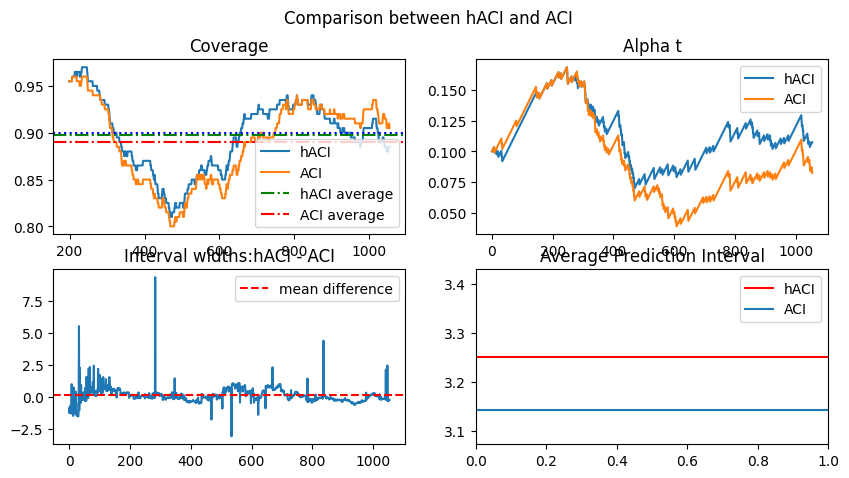

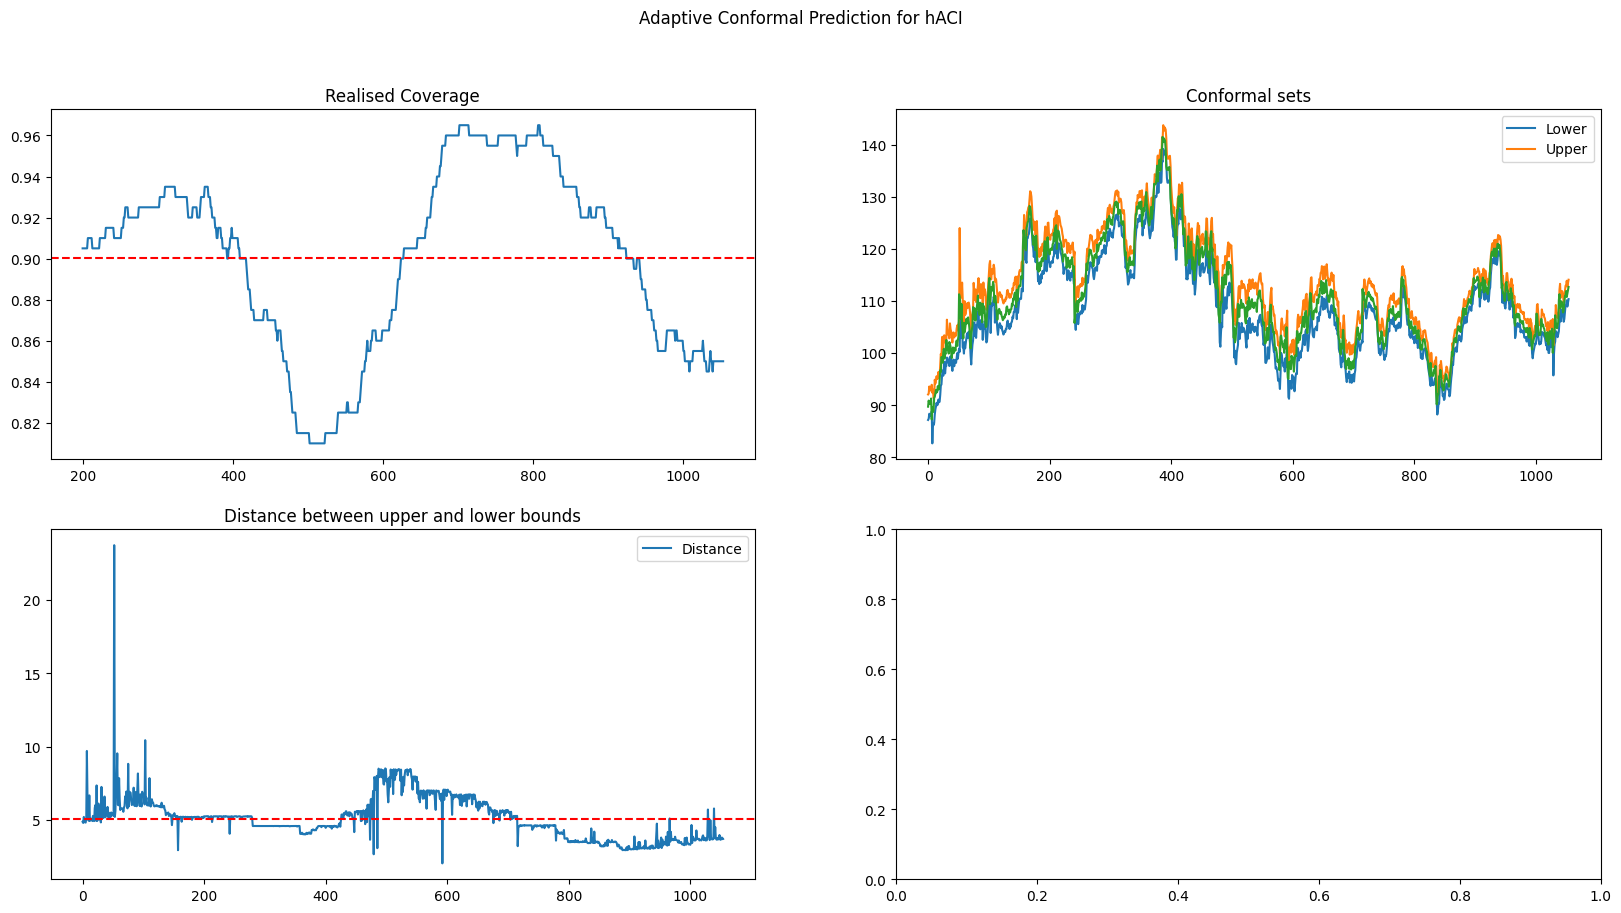

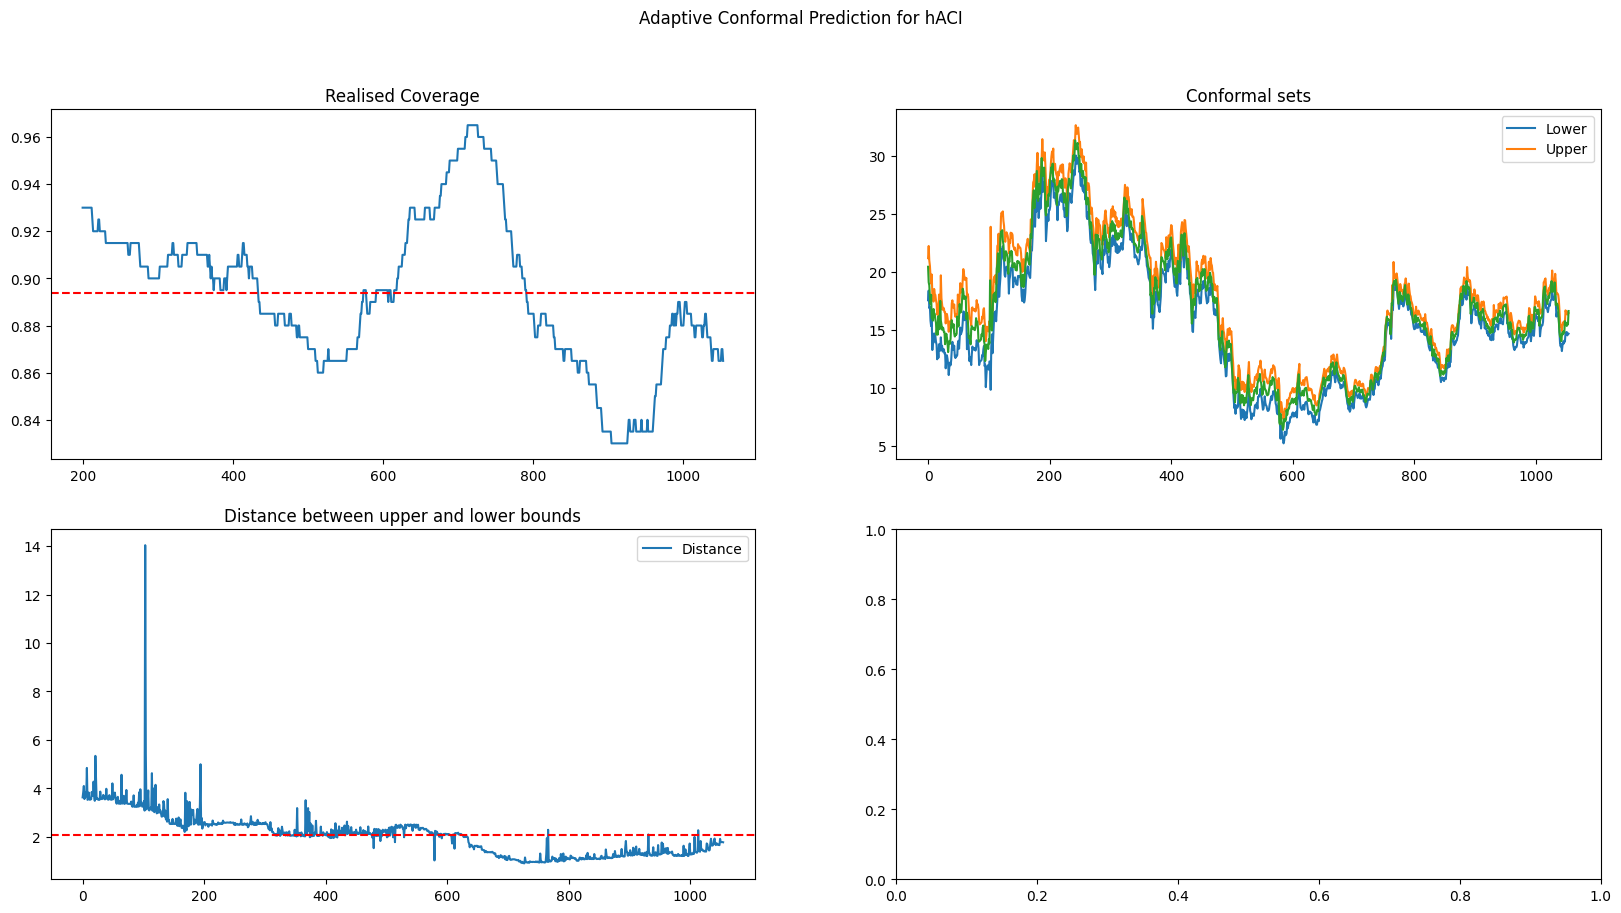

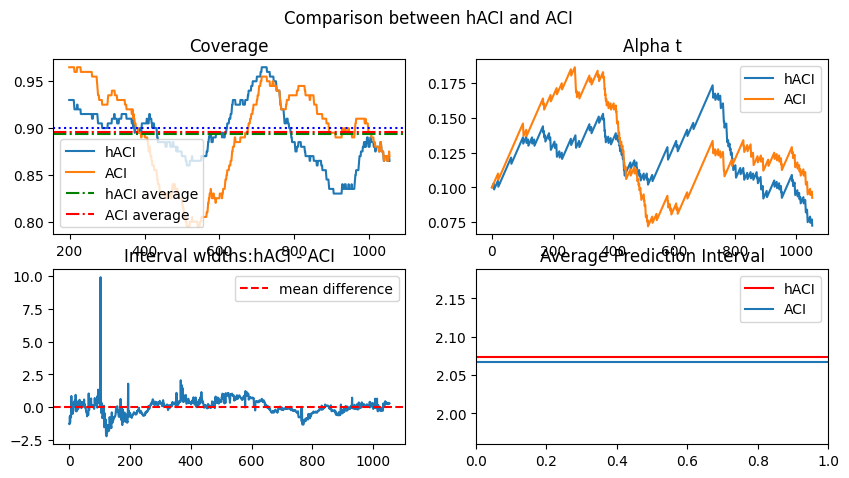

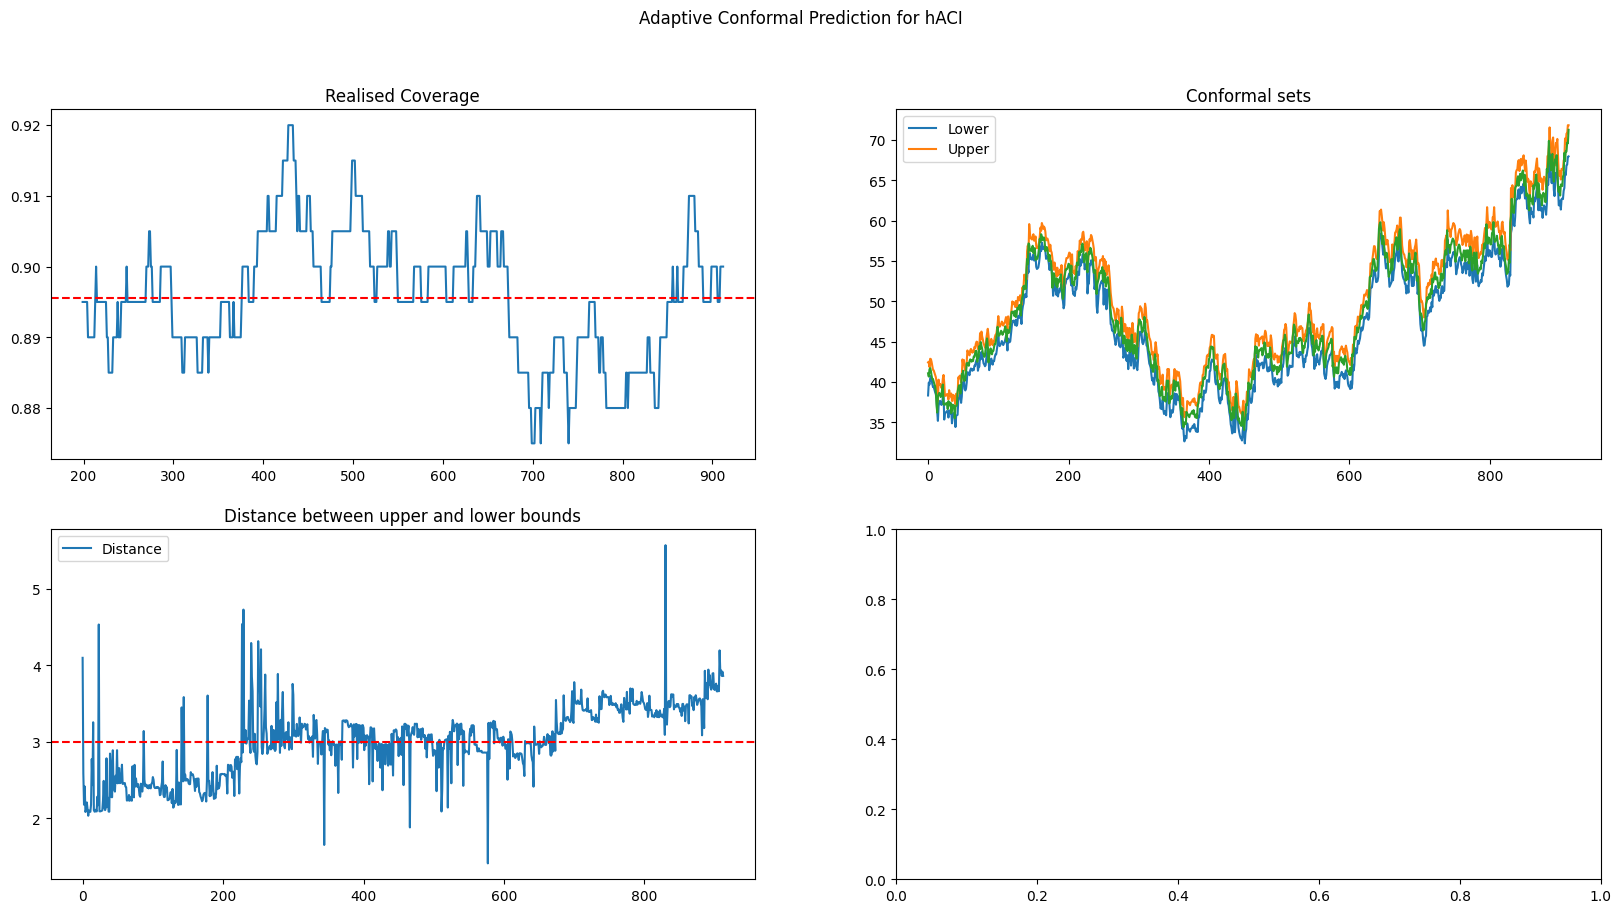

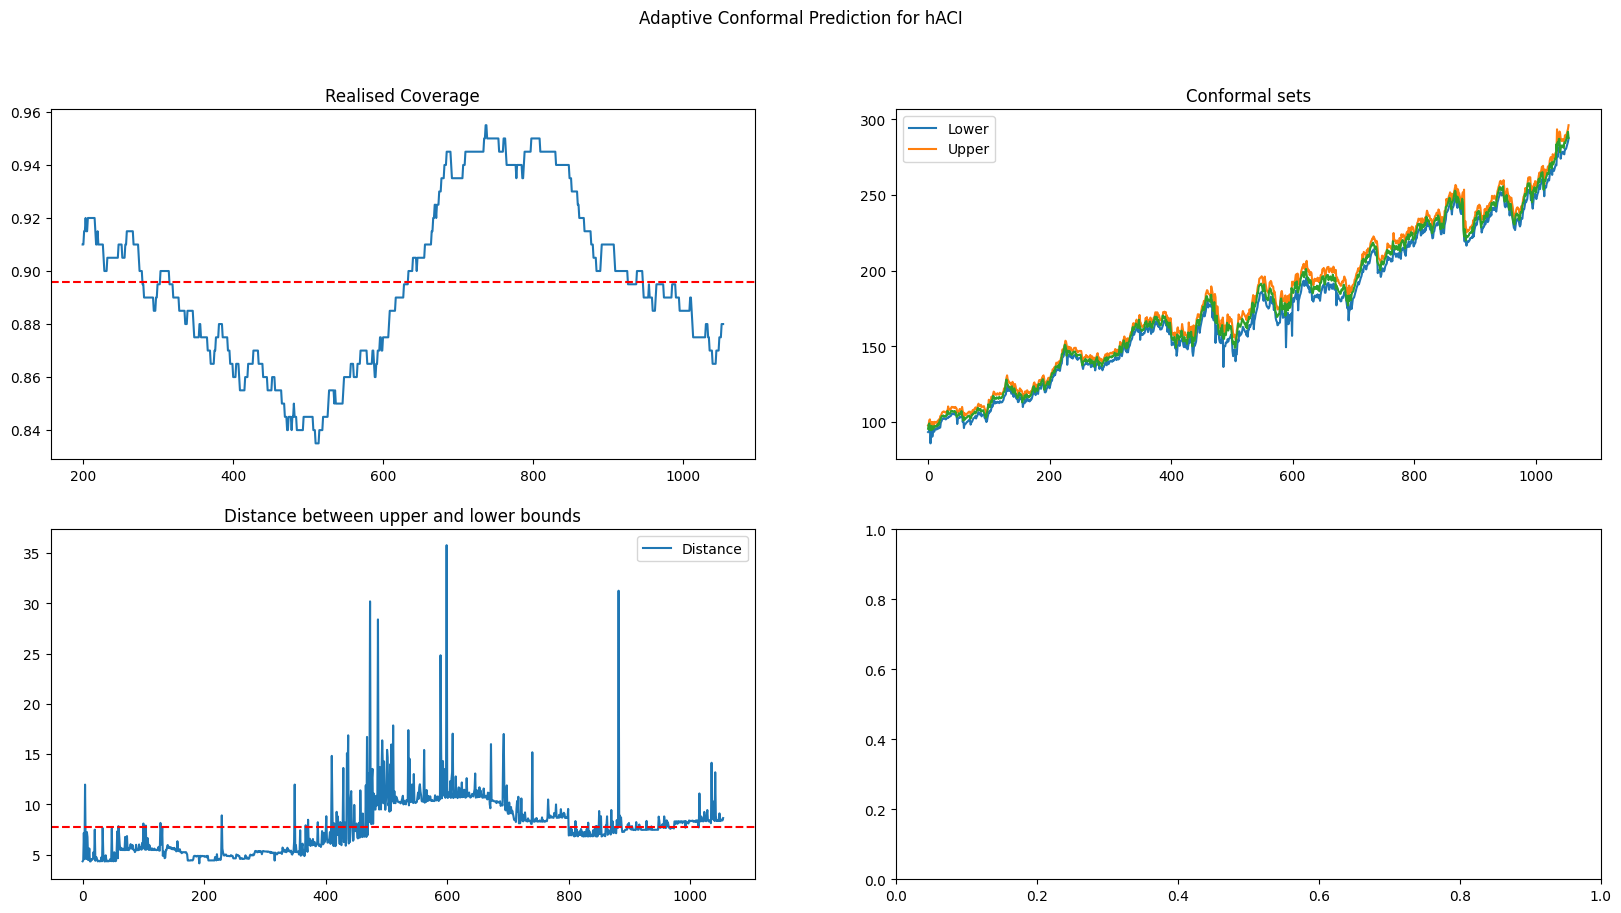

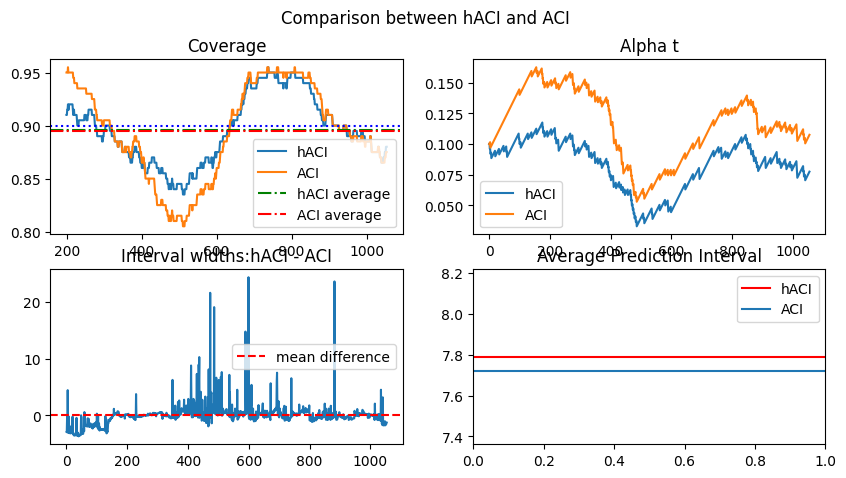

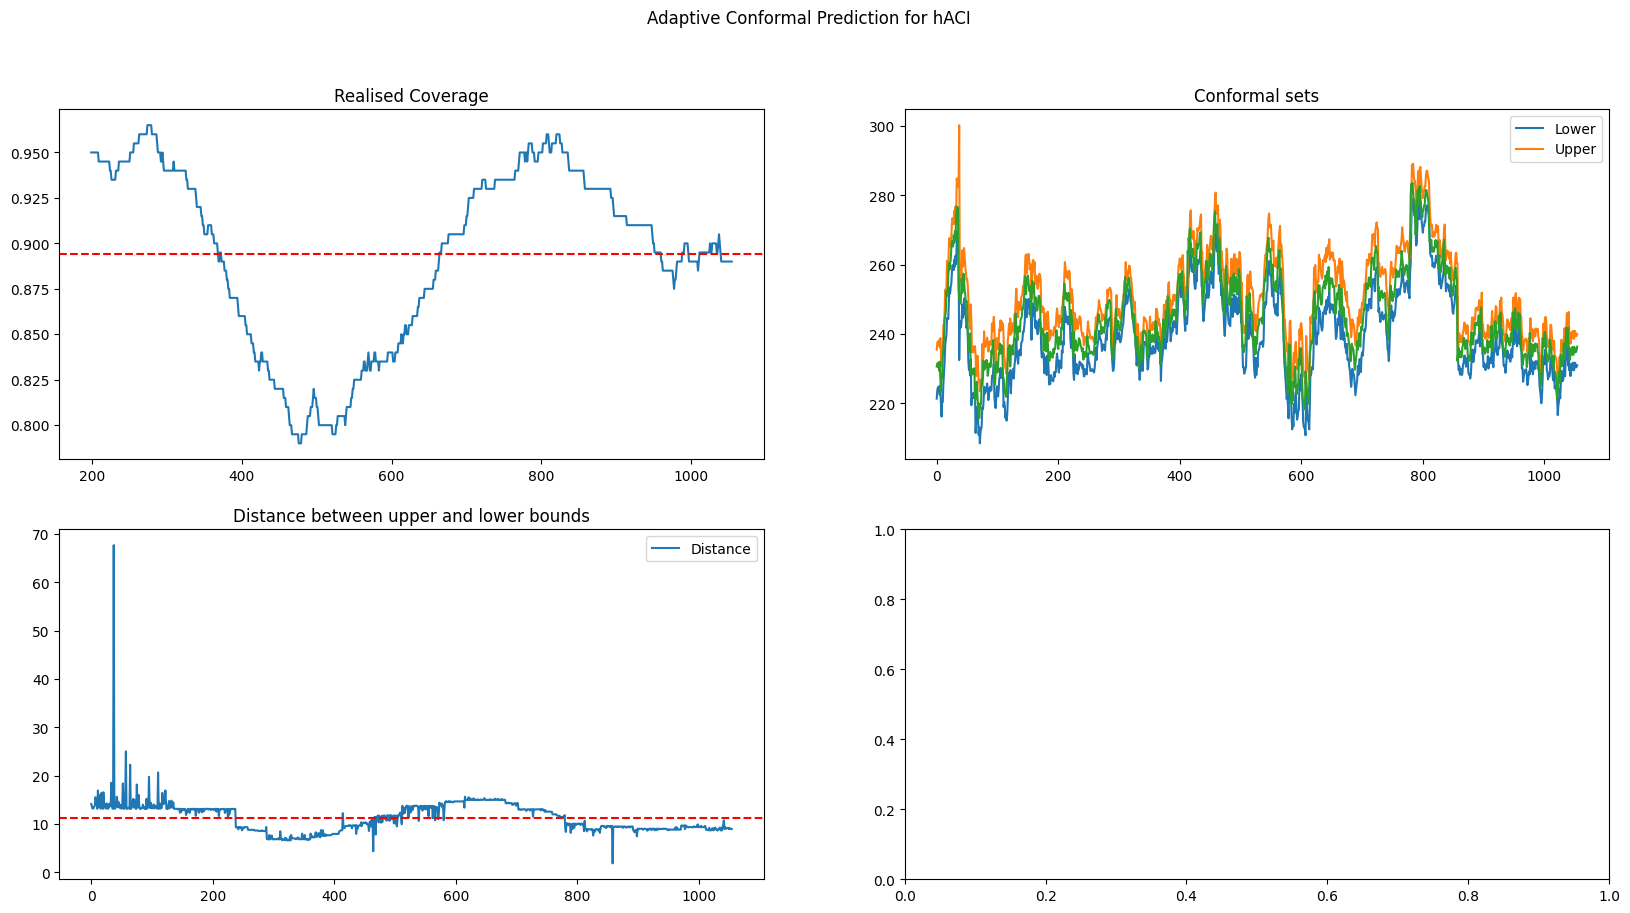

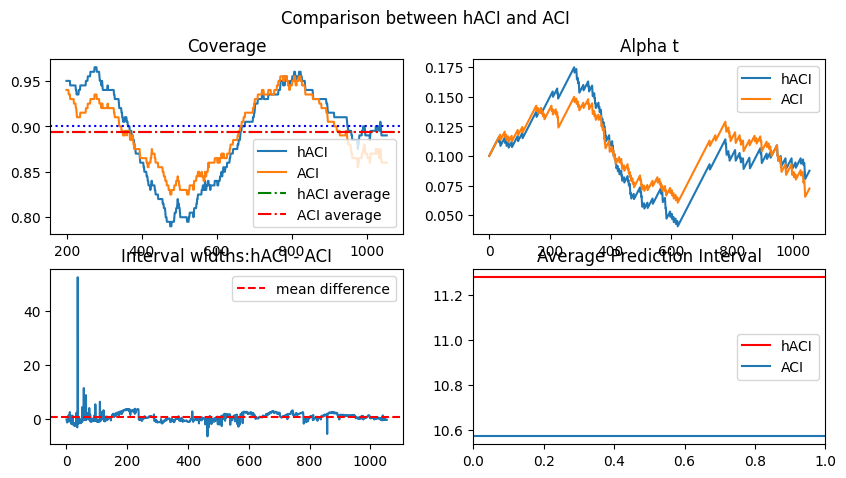

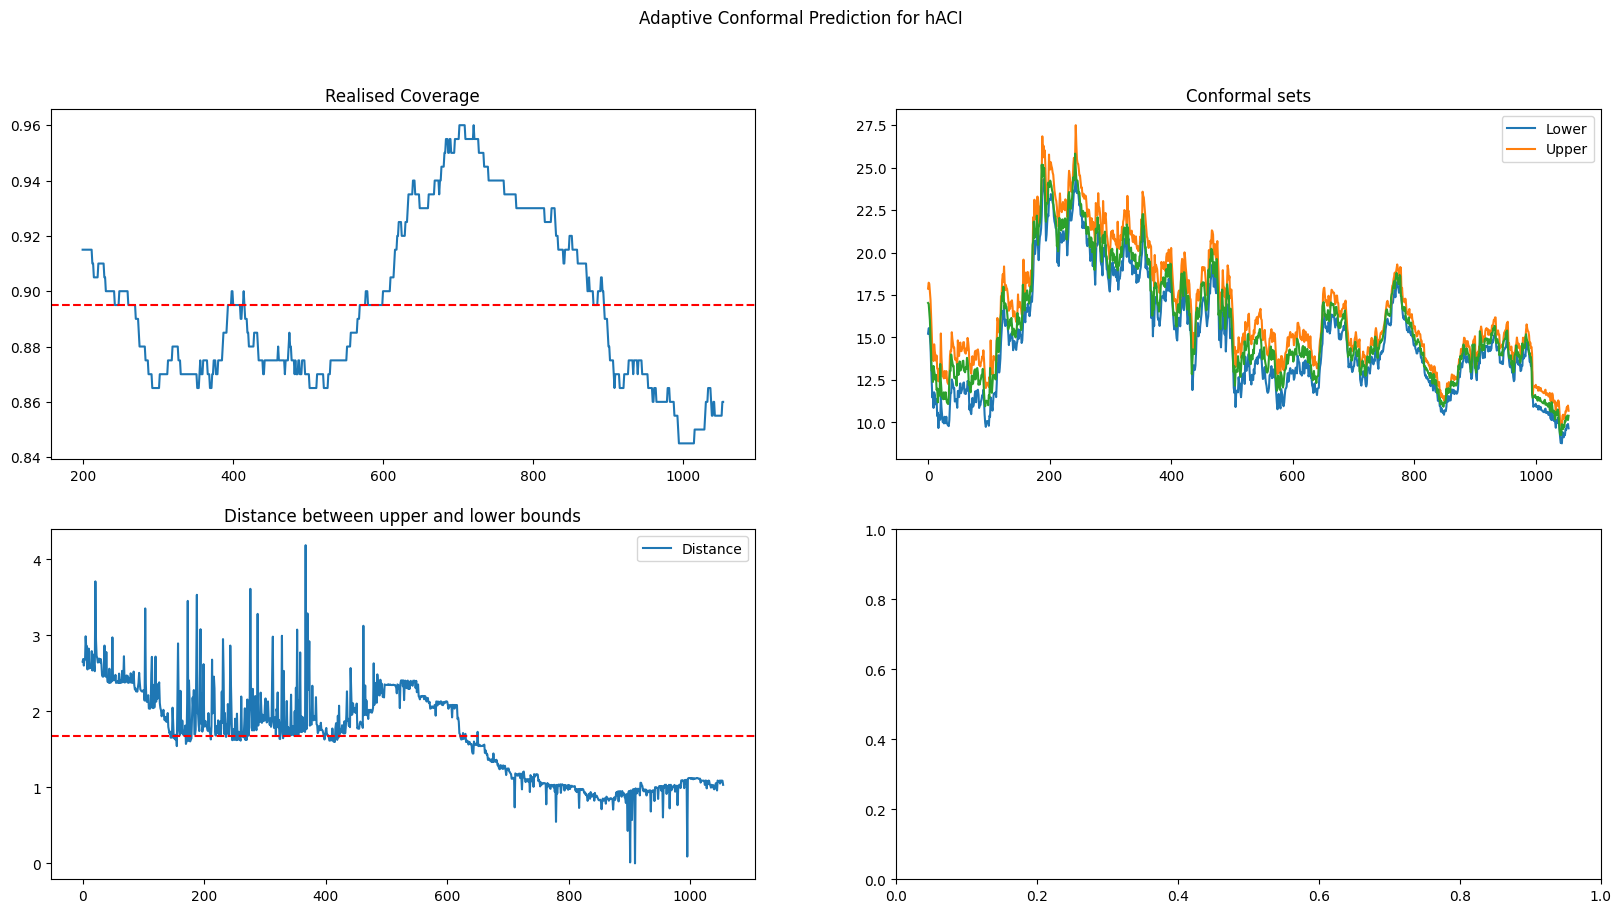

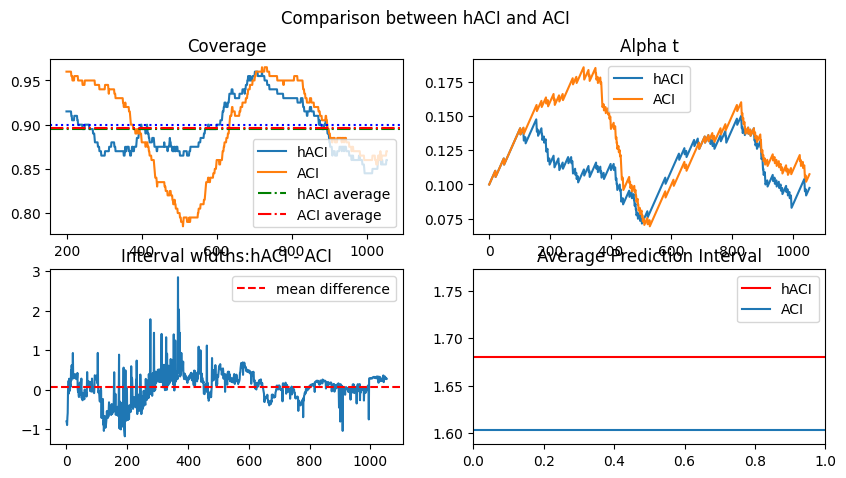

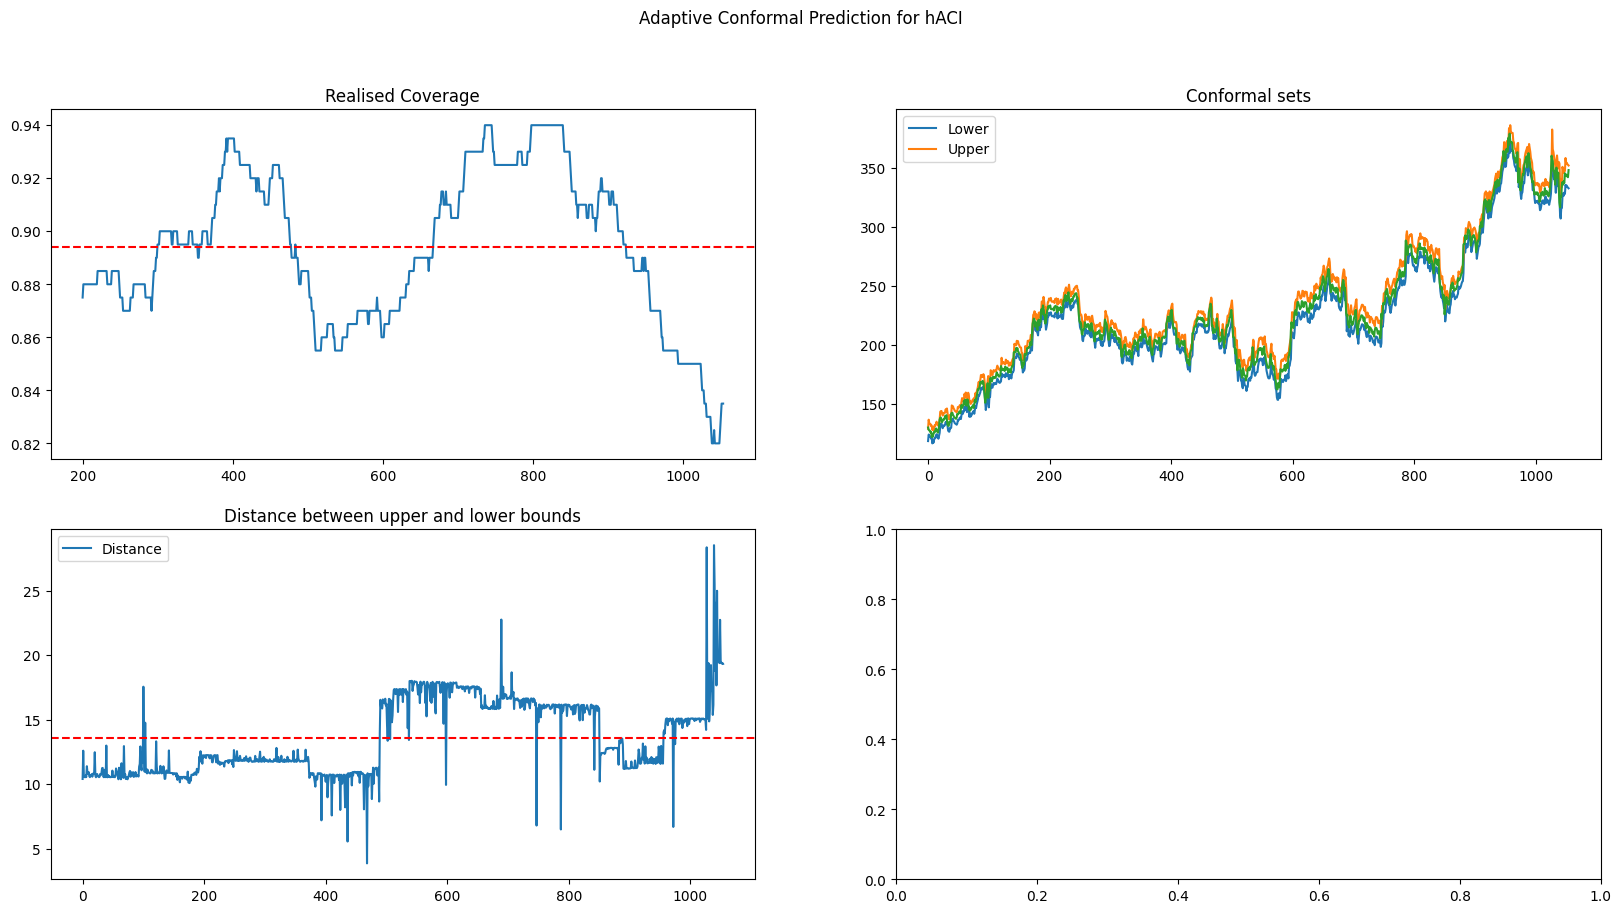

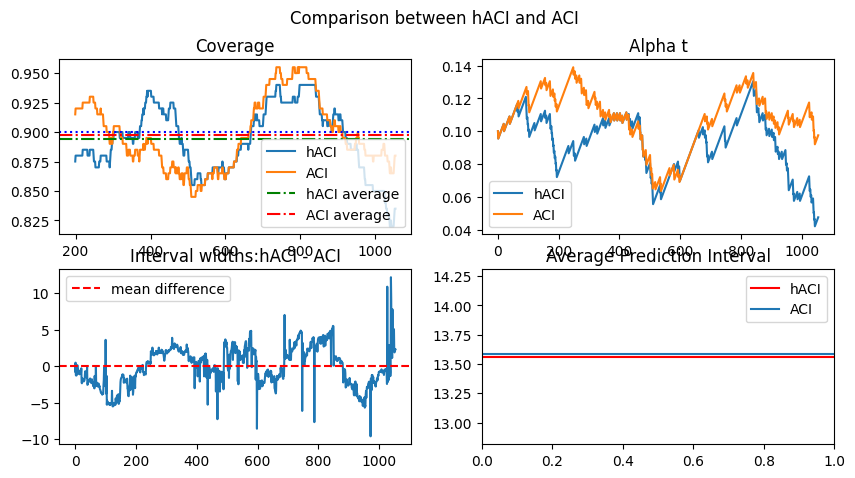

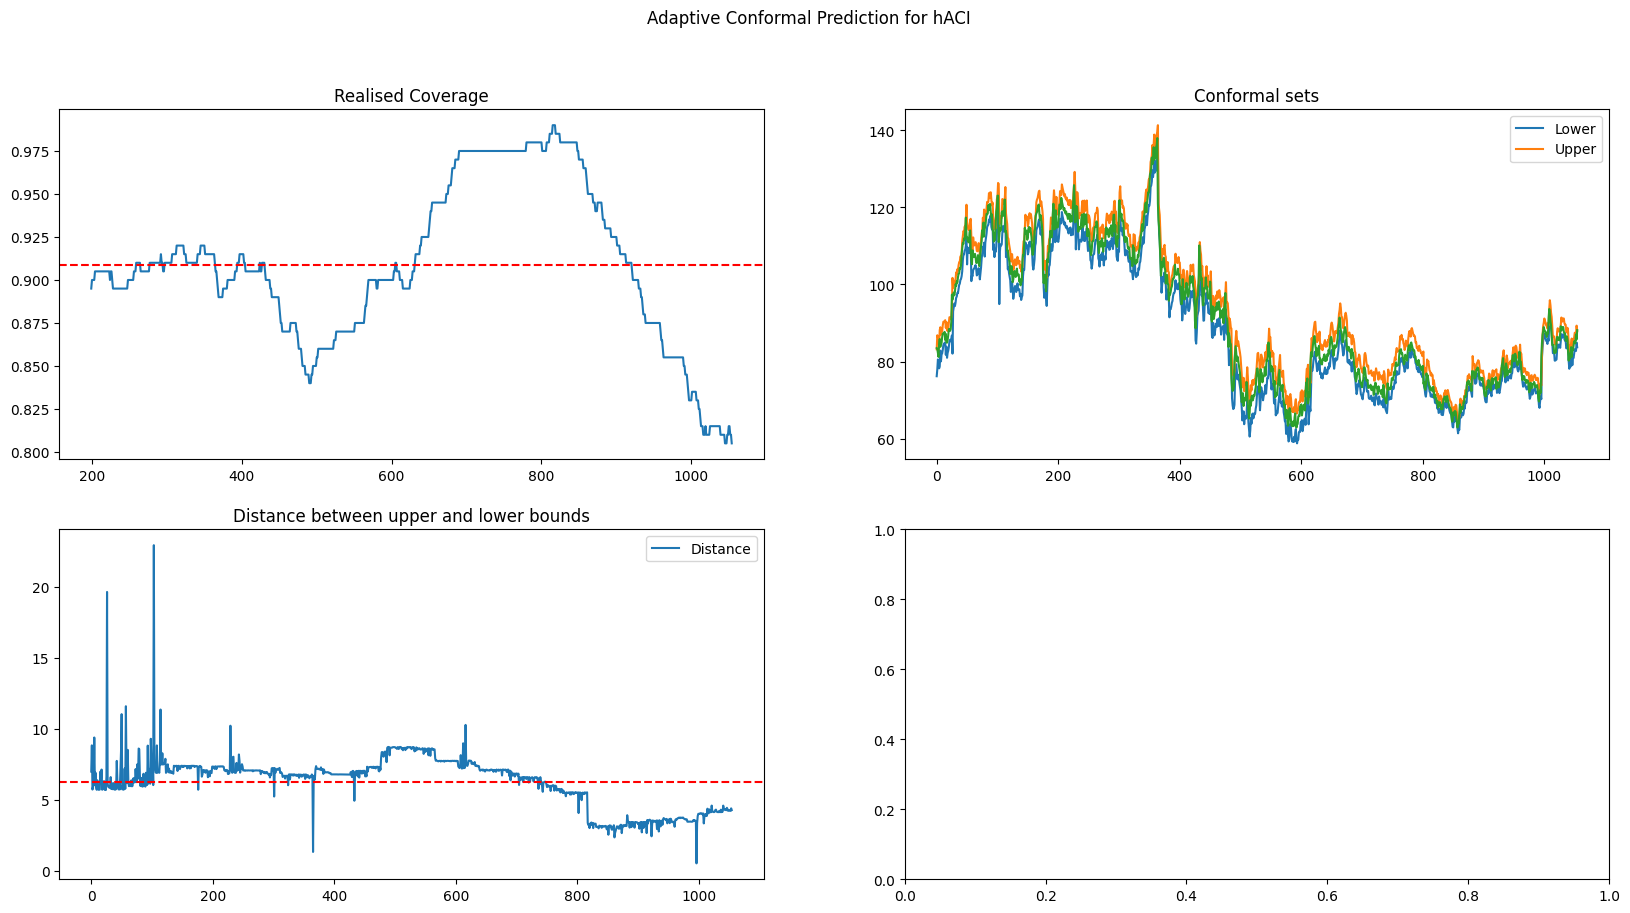

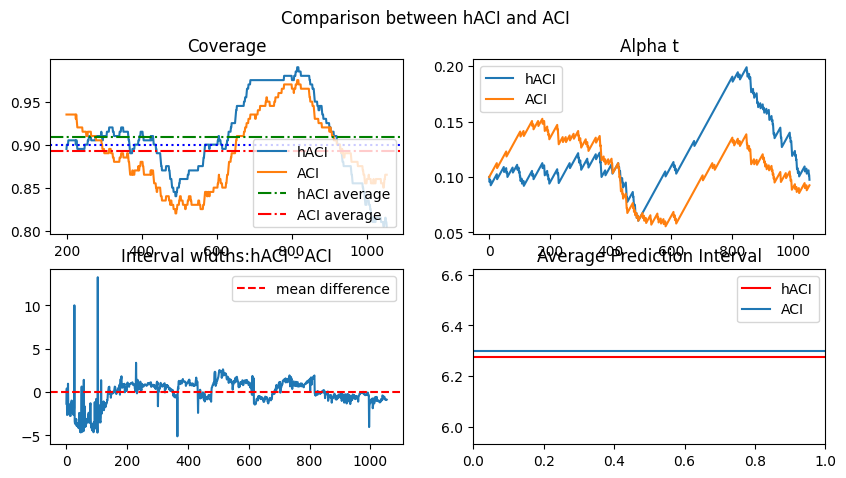

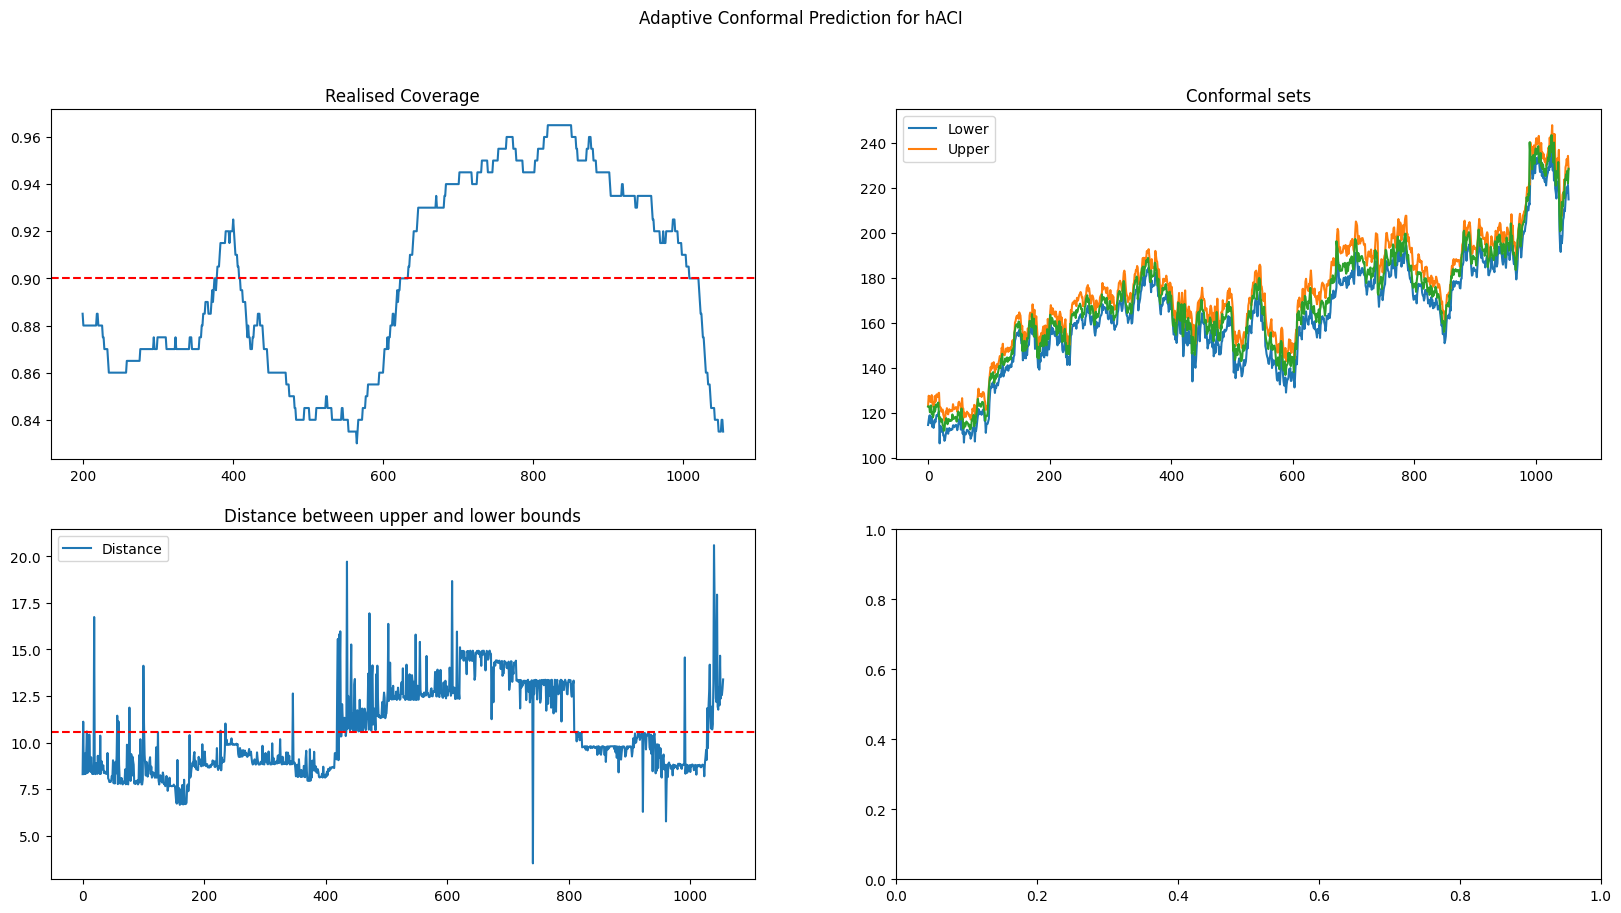

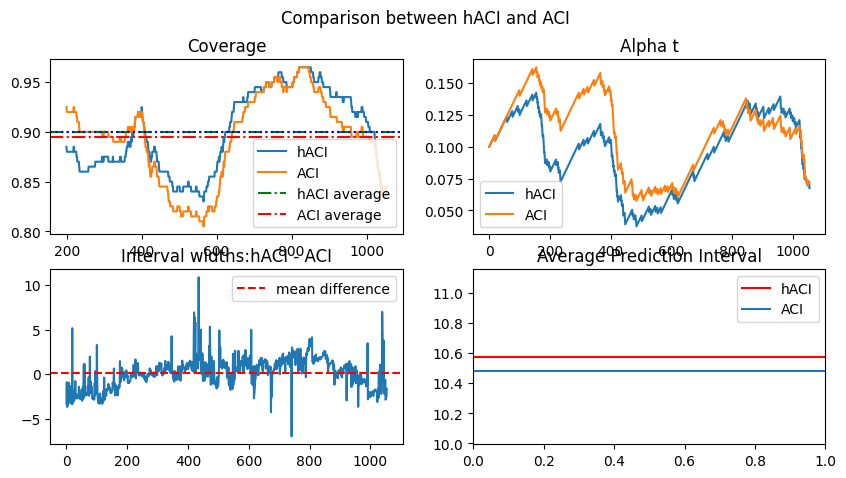

In [119]:
for i in range(10):
    test_with_comparison()

hACI is performing worse with a shit model for variance. 

The params are just learning to zero out. Does this means that the scores are zero?
Why would this not happen for the differences which is essentialy what we have.

You were debugging the whole time and it was copilots fault for fuck skae.

In [149]:
def test_one_side():
    stock = [stock_data[random.randint(0,99)]]
    final_stock = xvy_from_ACP(stock)[0]
    h = hACP(0.1, 200)
    result = h.HACI_one_side(final_stock, 0.005)
    ACP_plots.one_plot(result, final_stock[2])
    return result

def test_with_comparison(method):
    stock = [stock_data[random.randint(0,99)]]
    cleaned_stock_data = xvy_from_ACP(stock,)[0]
    corrected_stock_data = xvy_correction(stock)[0]

    h = hACP(0.1, 200)
    result = method(h, cleaned_stock_data, 0.0025, title='hACI')
    comparison = h.ACI(corrected_stock_data, 0.005)

    ACP_plots.one_plot(result, cleaned_stock_data[2])
    ACP_plots.compare_two(result, comparison)

    return result, comparison

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000000000001, 0.05775000000000001, 0.05800000000000001, 0.05825000000000001, 0.05850000000000001, 0.05875000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000000000001, 0.05775000000000001, 0.05800000000000001, 0.05825000000000001, 0.05850000000000001, 0.05875000000000001, 0.05900000000000001, 0.05925000000000001, 0.05950000000000001,

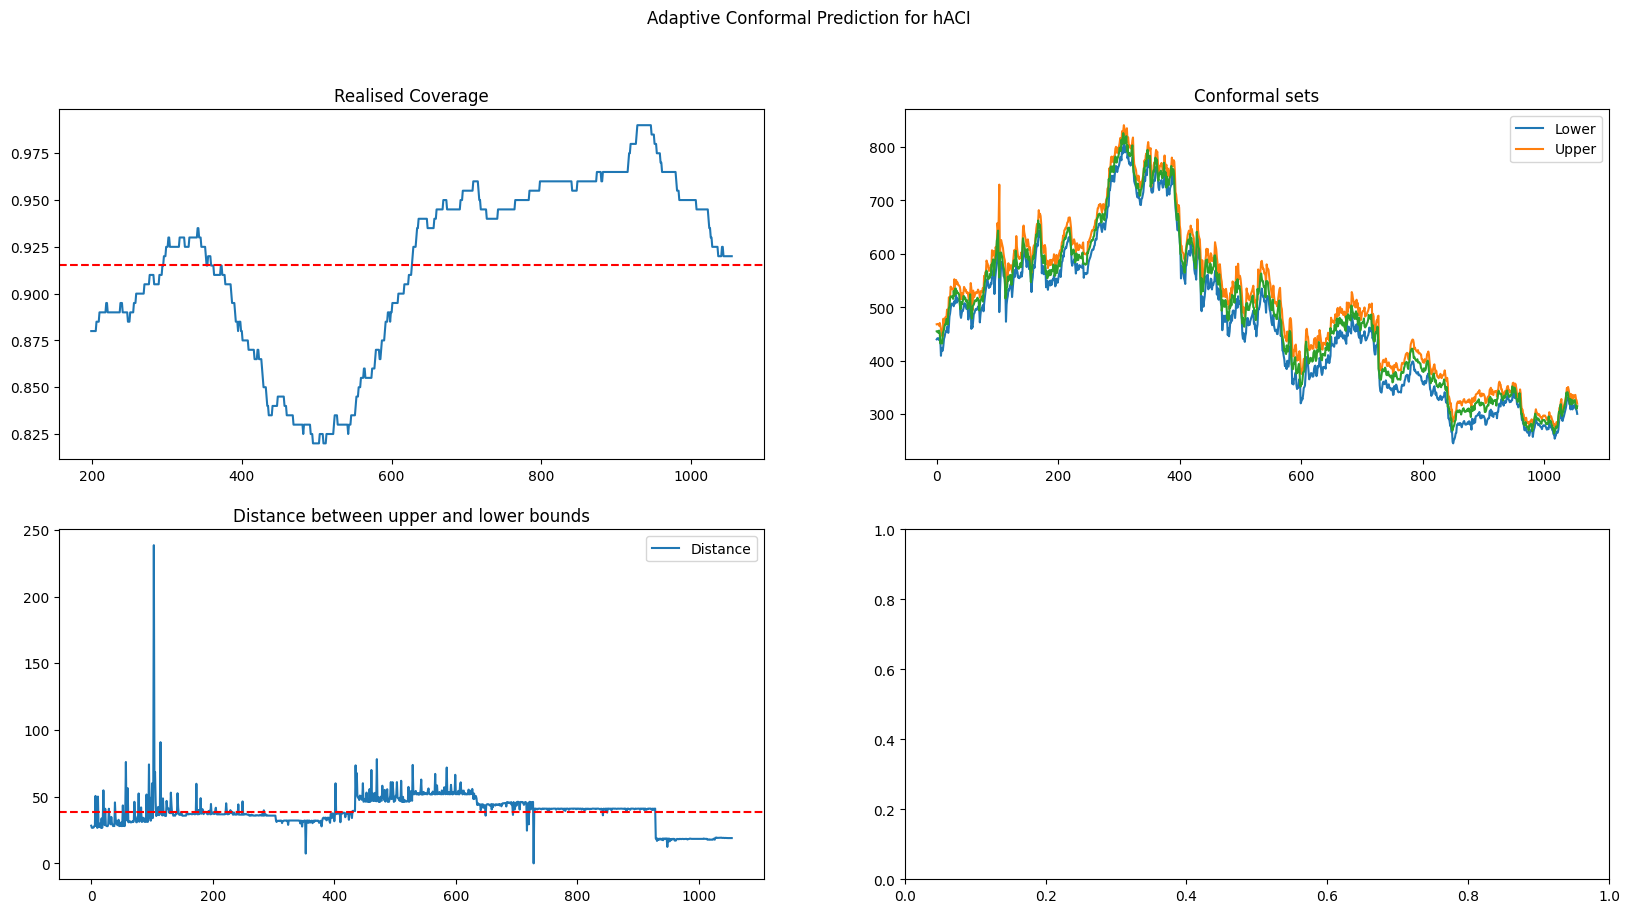

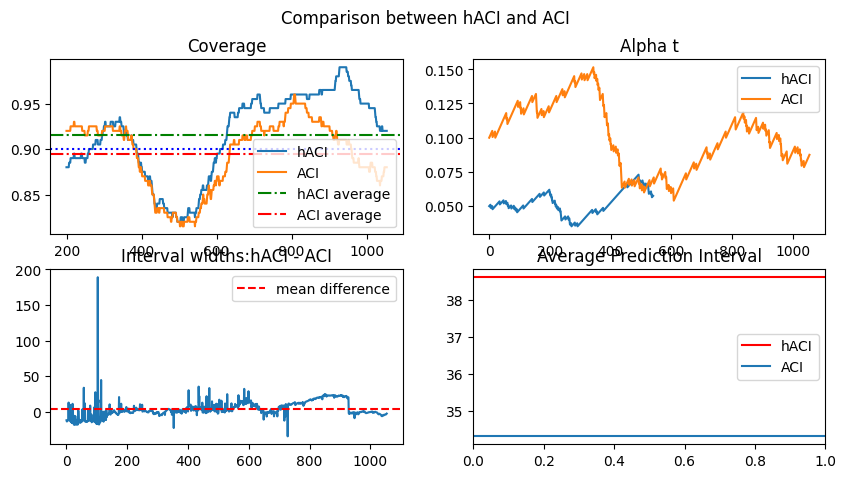

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.048, 0.04575, 0.046, 0.04625, 0.0465, 0.04675, 0.047, 0.04475, 0.045, 0.04525, 0.0455, 0.04575, 0.046, 0.04625, 0.044, 0.041749999999999995, 0.041999999999999996, 0.042249999999999996, 0.042499999999999996, 0.042749999999999996, 0.043, 0.04325, 0.0435, 0.041249999999999995, 0.041499999999999995, 0.041749999999999995, 0.03949999999999999, 0.039749999999999994, 0.039999999999999994, 0.040249999999999994, 0.040499999999999994, 0.040749999999999995, 0.040999999999999995, 0.041249999999999995, 0.041499999999999995, 0.041749999999999995, 0.041999999999999996, 0.042249999999999996, 0.042499999999999996, 0.042749999999999996, 0.043, 0.04325, 0.0435, 0.041249999999999995, 0.041499999999999995, 0.041749999999999995, 0.041999999999999996, 0.042249999999999996, 0.0424

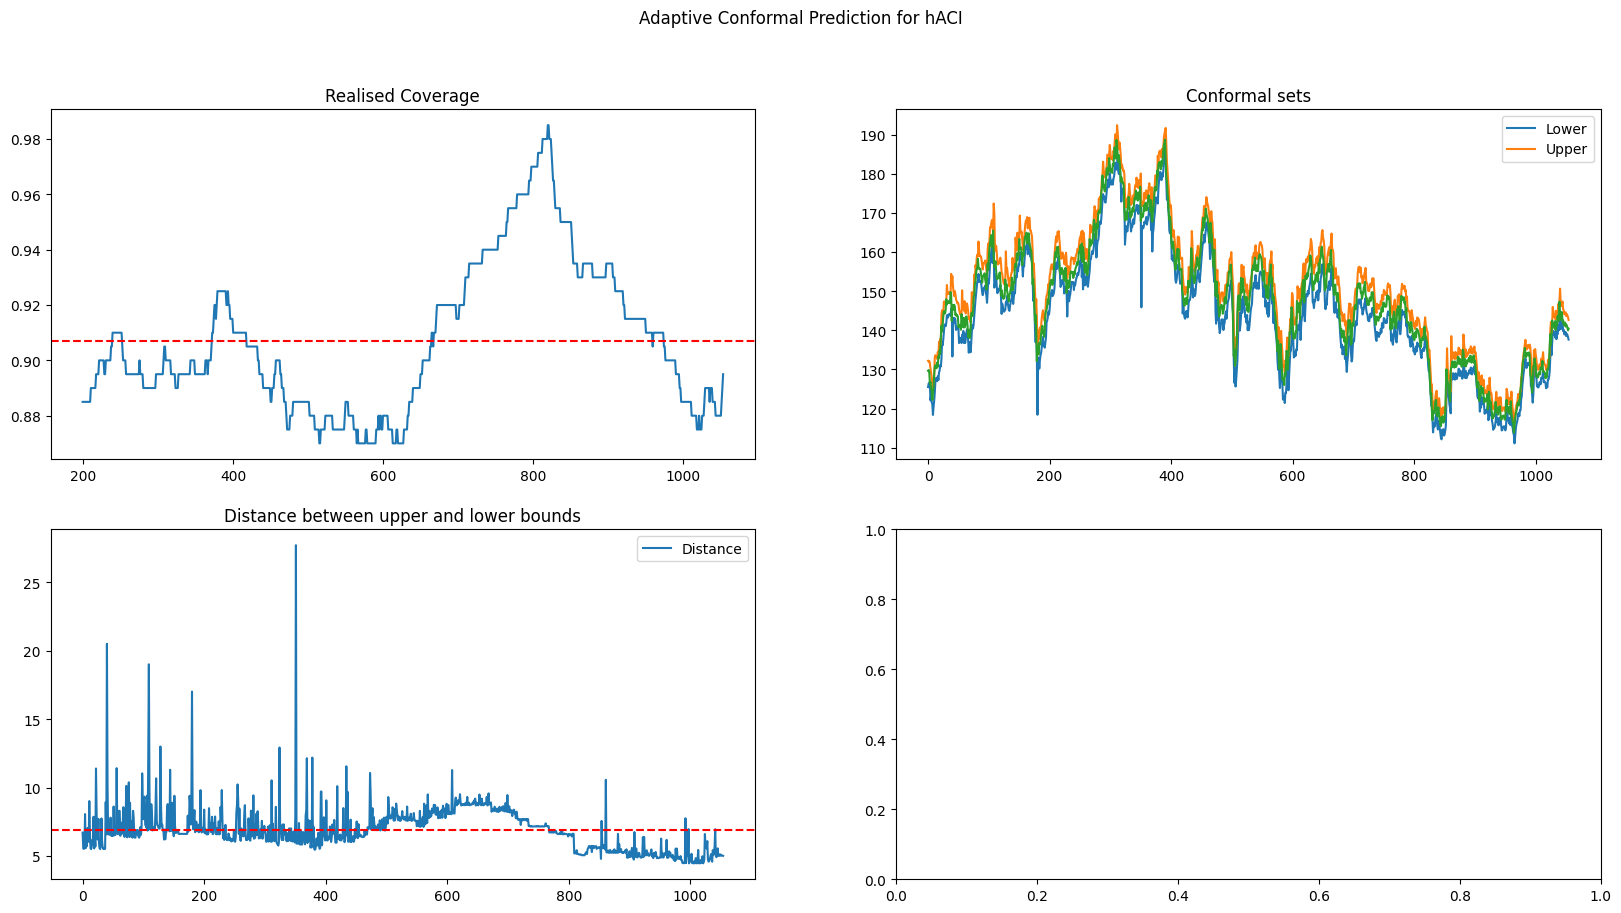

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000000000001, 0.05775000000000001, 0.05800000000000001, 0.05825000000000001, 0.05850000000000001, 0.05875000000000001, 0.05900000000000001, 0.05925000000000001, 0.0595000000

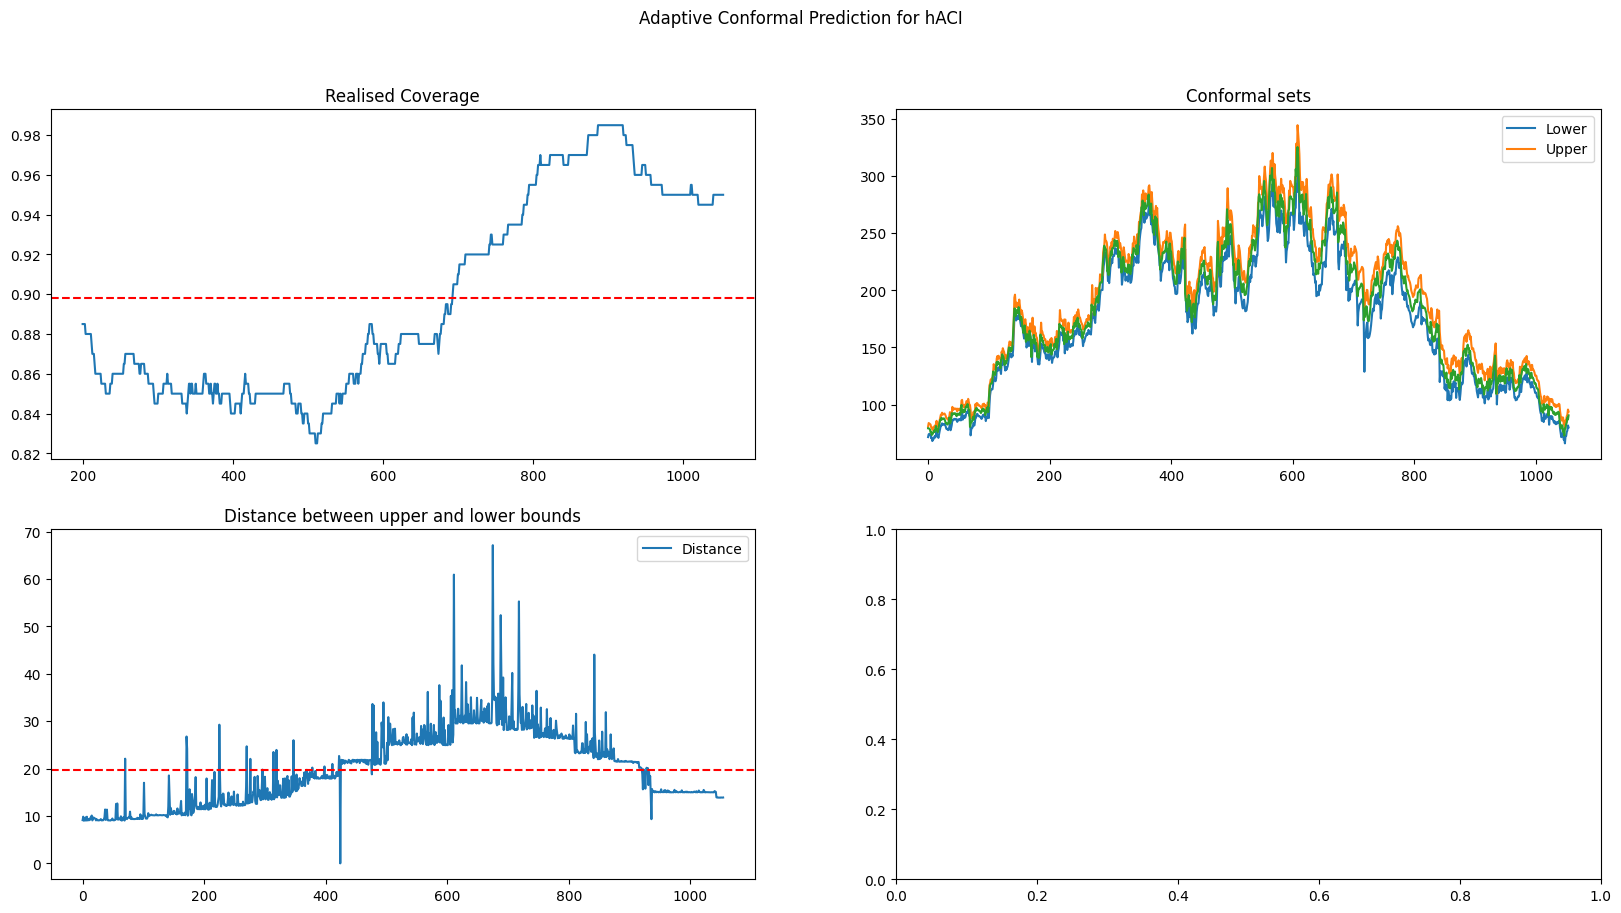

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.0547500

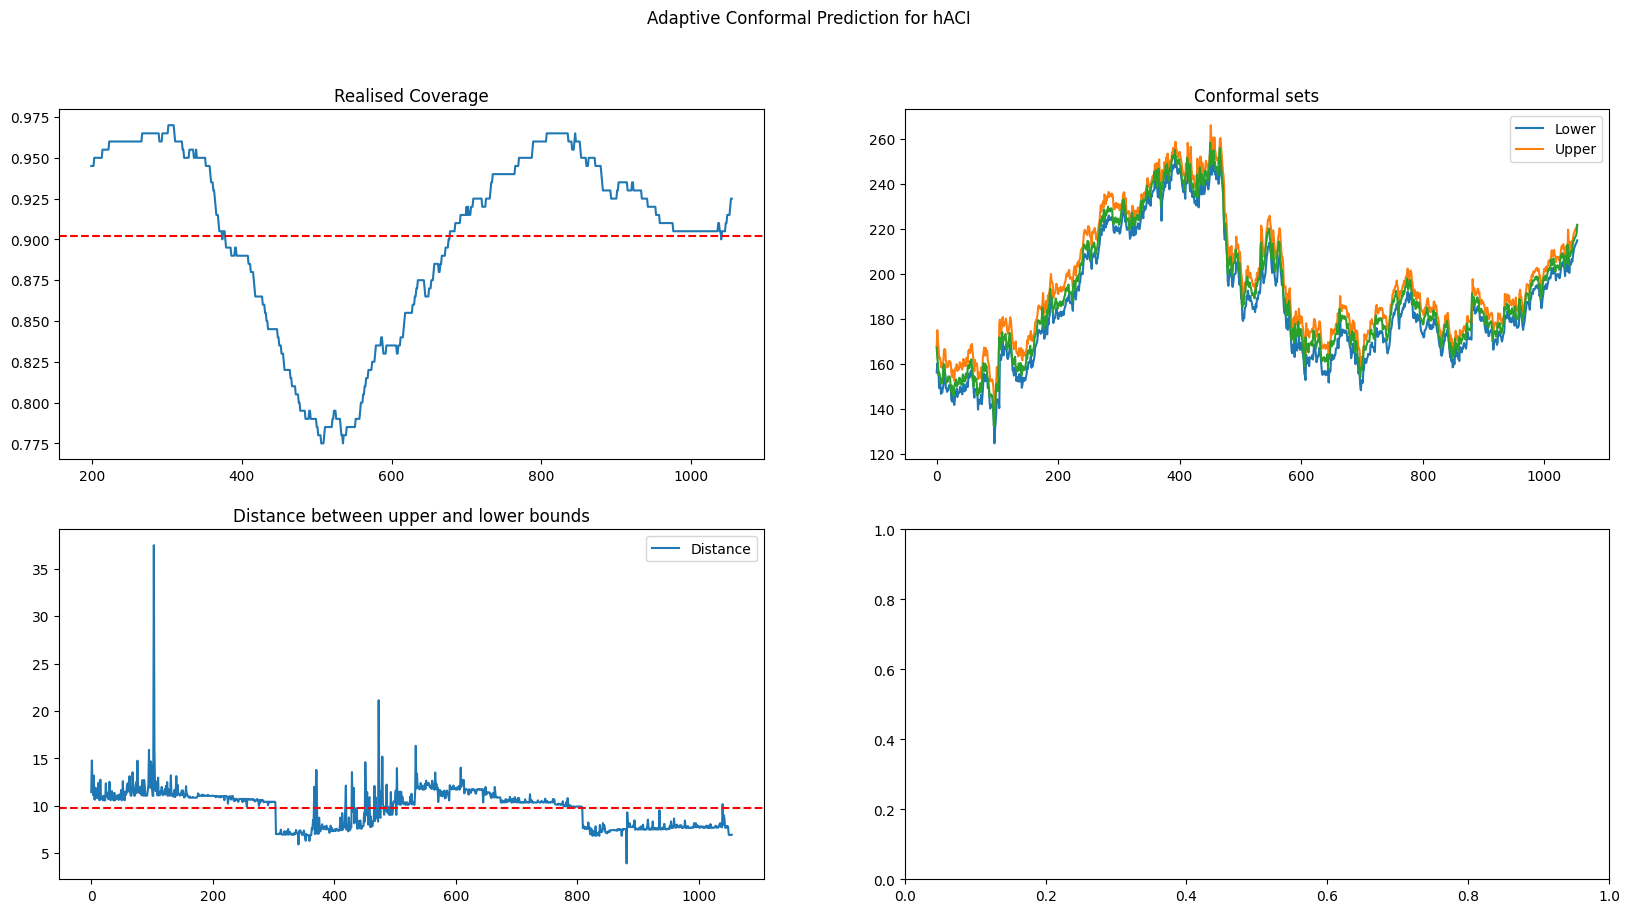

{'lower': [0.05, 0.05025, 0.0505, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.047, 0.04725, 0.0475, 0.04775, 0.048, 0.04825, 0.046, 0.04625, 0.0465, 0.04675, 0.047, 0.04725, 0.0475, 0.04775, 0.048, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.04875, 0.049

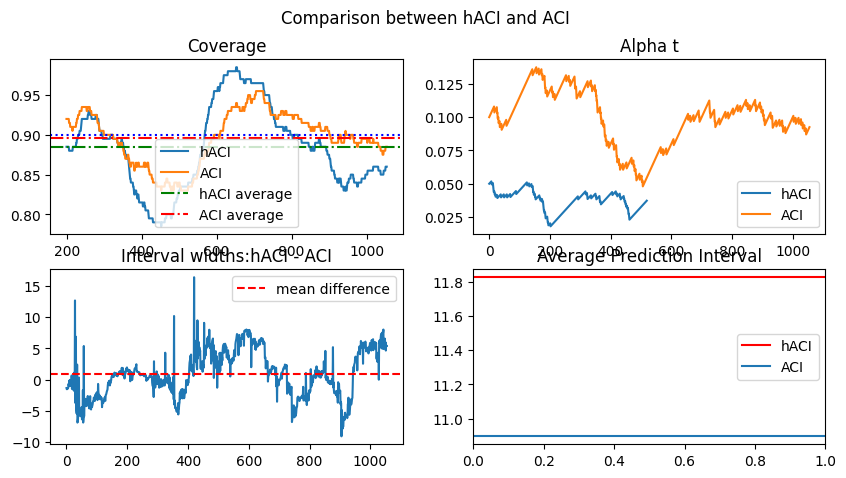

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.052250000000000005, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.04975, 0.05, 0.04775, 0.048, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.05

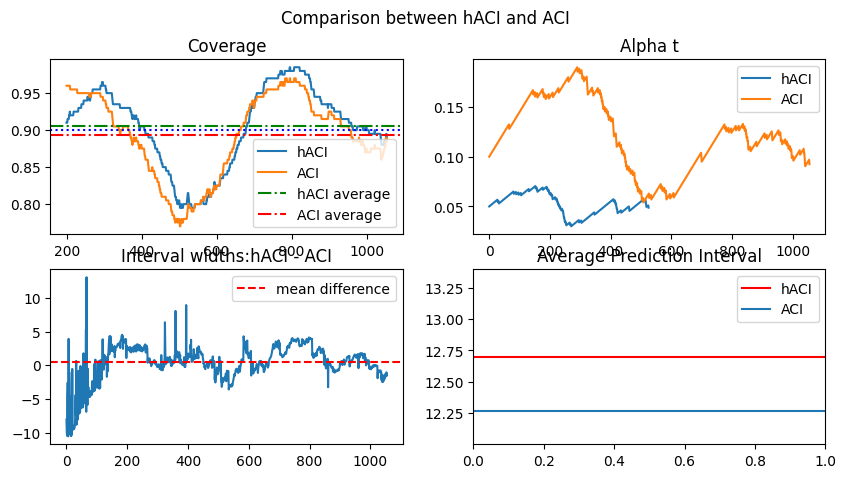

{'lower': [0.05, 0.05025, 0.048, 0.04825, 0.0485, 0.04625, 0.044, 0.04425, 0.0445, 0.04475, 0.045, 0.042749999999999996, 0.043, 0.04325, 0.0435, 0.04375, 0.044, 0.041749999999999995, 0.041999999999999996, 0.042249999999999996, 0.042499999999999996, 0.042749999999999996, 0.040499999999999994, 0.040749999999999995, 0.040999999999999995, 0.03874999999999999, 0.03899999999999999, 0.03924999999999999, 0.03949999999999999, 0.039749999999999994, 0.039999999999999994, 0.040249999999999994, 0.040499999999999994, 0.040749999999999995, 0.03849999999999999, 0.03874999999999999, 0.03899999999999999, 0.03674999999999999, 0.03699999999999999, 0.03724999999999999, 0.03749999999999999, 0.03774999999999999, 0.03799999999999999, 0.03574999999999999, 0.03599999999999999, 0.03624999999999999, 0.03399999999999999, 0.03424999999999999, 0.03449999999999999, 0.03474999999999999, 0.03499999999999999, 0.03524999999999999, 0.03549999999999999, 0.03324999999999999, 0.03349999999999999, 0.03374999999999999, 0.03399

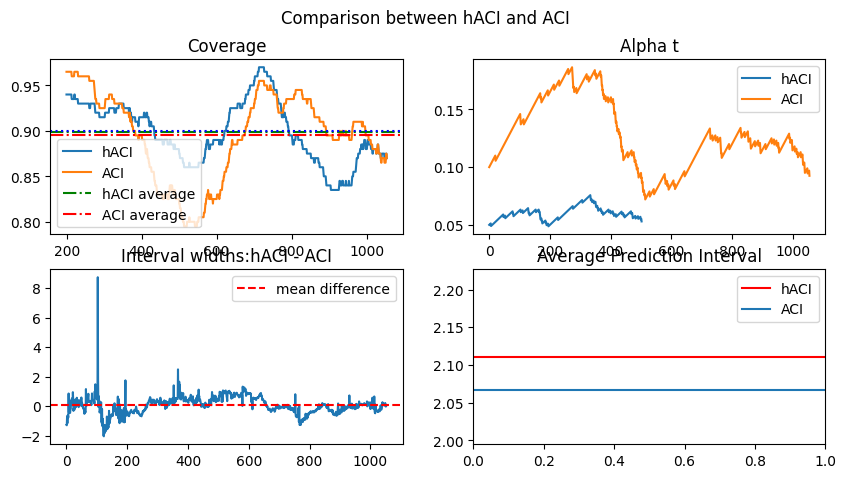

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000000000001, 0.05775000000000001, 0.05800000000000001, 0.05825000000000001, 0.058500

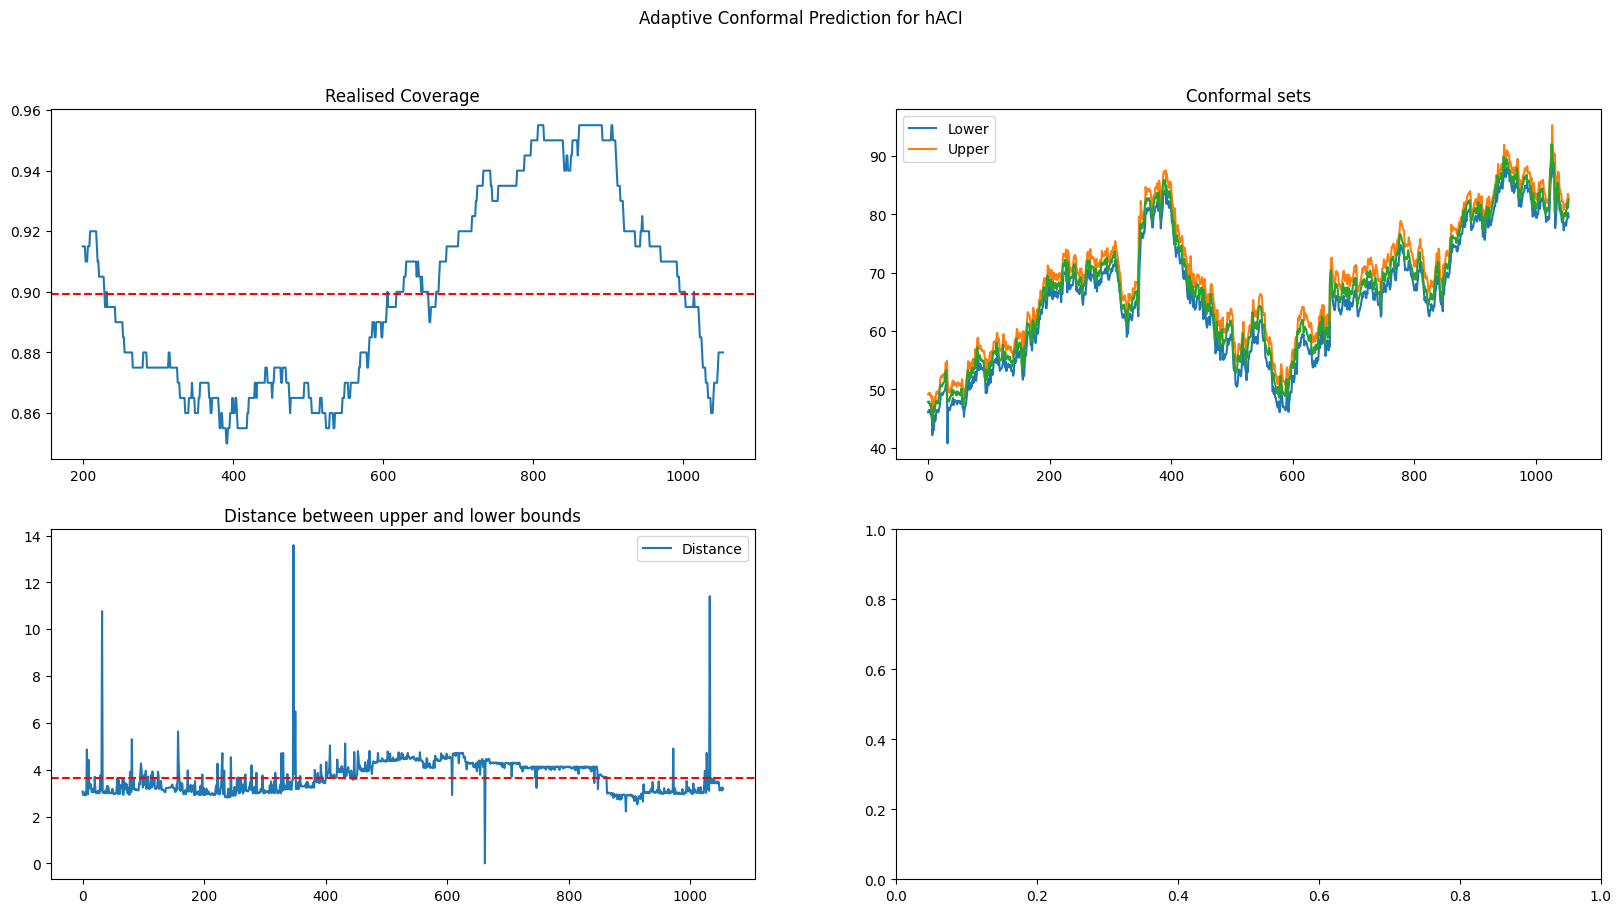

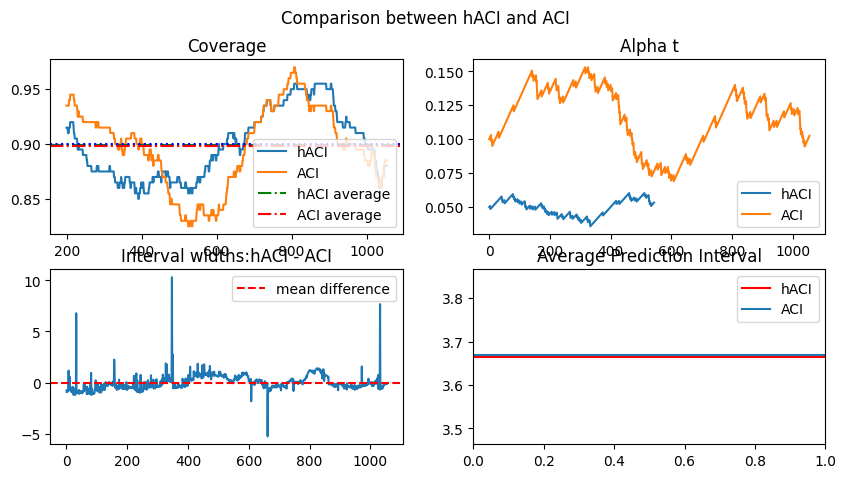

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000000000001, 0.05775000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05750000

{'lower': [0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051250000000000004, 0.051500000000000004, 0.051750000000000004, 0.052000000000000005, 0.052250000000000005, 0.052500000000000005, 0.052750000000000005, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.05525000000000001, 0.05550000000000001, 0.05575000000000001, 0.05600000000000001, 0.05625000000000001, 0.05650000000000001, 0.05675000000000001, 0.05700000000000001, 0.05725000000000001, 0.05500000000000001, 0.05525000000000001, 0.053000000000000005, 0.053250000000000006, 0.053500000000000006, 0.053750000000000006, 0.054000000000000006, 0.05425000000000001, 0.05450000000000001, 0.05475000000000001, 0.05500000000000001, 0.052750000000000005, 0.053000000000000005, 0.05075, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05, 0.05025, 0.0505, 0.05075, 0.051000000000000004, 0.051

In [150]:
for _ in range(10):
    r, _ = test_with_comparison(hACP.HACI_dual_tail)
    print(r['alpha_t_dict'])

How else could you innovate this?

- You could have a better optimising algorithm 
- 